# Data Science Research Project

The Data:
1. This data represents a technology which is in a remote location. It sends data periodically on its status – failure or not. It is very expensive to fix these machines because they are in remote areas and its failure is hard to predict. It is your job as the researcher to help us predict failures which may occur in the future
2. Historical file : predict_failure.csv

The Task
1. Research : Please create a predictive model using a jupyter notebook.
    a. Highlight your thought process in the notebook as you explore the data
    b. Showcase your best predictive model – and highlight why it’s the best
    c. Evaluate your model

First we read the data and explore it

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.model_selection import KFold,GridSearchCV

In [3]:
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('TakeHomeTest/predict_failure.csv')

In [5]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
df.shape

(124494, 12)

In [7]:
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
df['date'].min(),df['date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-11-02 00:00:00'))

In [10]:
df.dtypes

date          datetime64[ns]
device                object
failure                int64
attribute1             int64
attribute2             int64
attribute3             int64
attribute4             int64
attribute5             int64
attribute6             int64
attribute7             int64
attribute8             int64
attribute9             int64
dtype: object

In [11]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


# lets collect enough samples for device that had failures

In [12]:
print('Out of {} we have {} unique devices'.format(df.shape[0],df['device'].nunique()))

Out of 124494 we have 1168 unique devices


In [13]:
df1 = (df.groupby(['device'])['failure'].nunique()>1).reset_index()
df1 = df1[df1.failure==True]
final_df = df1.merge(df,on='device',how='left',suffixes=['_happend',''])

In [14]:
final_df.head()

,device,failure_happend,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,S1F023H2,True,2015-01-01,0,141503600,0,0,1,19,494462,16,16,3
1,S1F023H2,True,2015-01-02,0,161679800,0,0,1,19,495730,16,16,3
2,S1F023H2,True,2015-01-03,0,182358672,0,0,1,19,496974,16,16,3
3,S1F023H2,True,2015-01-04,0,204752808,0,0,1,19,497559,16,16,3
4,S1F023H2,True,2015-01-05,0,226982888,0,0,1,19,498753,16,16,3


In [15]:
final_df.shape

(10713, 13)

In [16]:
#there are only some of the devices that have both zero and one values and this is part of the data that we can use 
#for our model training then these are devices that we can have a good prediction for

final_df.device.nunique()

106

### Create a variable with device life time duration

In [17]:
for device in final_df.device.unique():
   # final_df.loc[final_df.device==device,'fail_date'] = 
    device_last_date = final_df.loc[(final_df.device==device)&(final_df.failure==1),'date']
    final_df.loc[final_df.device==device,'fail_date']=device_last_date.values         

In [18]:
final_df['fail_date'] = pd.to_datetime(final_df['fail_date'])

In [19]:
final_df['lifeTime_remain'] = (final_df.fail_date - final_df.date).dt.days

In [20]:
final_df.head()

,device,failure_happend,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,fail_date,lifeTime_remain
0,S1F023H2,True,2015-01-01,0,141503600,0,0,1,19,494462,16,16,3,2015-01-19,18
1,S1F023H2,True,2015-01-02,0,161679800,0,0,1,19,495730,16,16,3,2015-01-19,17
2,S1F023H2,True,2015-01-03,0,182358672,0,0,1,19,496974,16,16,3,2015-01-19,16
3,S1F023H2,True,2015-01-04,0,204752808,0,0,1,19,497559,16,16,3,2015-01-19,15
4,S1F023H2,True,2015-01-05,0,226982888,0,0,1,19,498753,16,16,3,2015-01-19,14


## drop data with negative lifetime_balace 
       it means after failure the test has been started for the device and 
       since each device only had one failure in total we easily drop these extra tests
       which only happens for 5 of the devices

In [21]:
final_df.loc[final_df.lifeTime_remain<0,'device'].nunique()

5

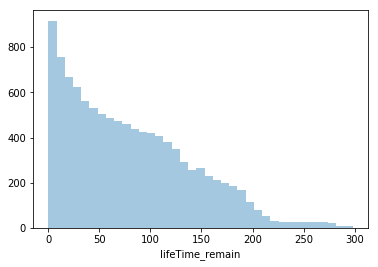

In [22]:
final_df = final_df.loc[final_df.lifeTime_remain>=0]
sns.distplot(final_df.lifeTime_remain,kde=False)
plt.show()

In [24]:
final_df.lifeTime_remain.describe()

count    10666.000000
mean        79.839021
std         60.238346
min          0.000000
25%         29.000000
50%         69.000000
75%        119.000000
max        298.000000
Name: lifeTime_remain, dtype: float64

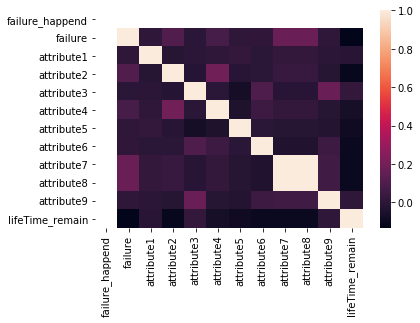

In [23]:
sns.heatmap(final_df.corr())

# using 80% of device for train and the rest for test

In [25]:
train_devices = list(np.random.choice(final_df.device.unique(),
                                      replace=False,
                                      size=int(0.8*final_df.device.nunique())))

In [26]:
len(train_devices)

84

In [27]:
test_devices = [device for device in list(final_df.device.unique()) if device not in train_devices]

In [28]:
len(test_devices)

22

In [29]:
train_df = final_df.loc[final_df.device.isin(train_devices)]
test_df = final_df.loc[final_df.device.isin(test_devices)]

In [30]:
train_df.shape,test_df.shape

((8009, 15), (2657, 15))

In [31]:
train_df.head()

,device,failure_happend,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,fail_date,lifeTime_remain
0,S1F023H2,True,2015-01-01,0,141503600,0,0,1,19,494462,16,16,3,2015-01-19,18
1,S1F023H2,True,2015-01-02,0,161679800,0,0,1,19,495730,16,16,3,2015-01-19,17
2,S1F023H2,True,2015-01-03,0,182358672,0,0,1,19,496974,16,16,3,2015-01-19,16
3,S1F023H2,True,2015-01-04,0,204752808,0,0,1,19,497559,16,16,3,2015-01-19,15
4,S1F023H2,True,2015-01-05,0,226982888,0,0,1,19,498753,16,16,3,2015-01-19,14


In [32]:
features = [feat for feat in train_df.columns if 'attribute' in feat]
features

['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

In [33]:
target = 'lifeTime_remain'

In [34]:
def regressor(x_train,y_train,x_test,y_test,classifier):
    y_pred = []
    if (classifier == 'tree'):
        rfr=RandomForestRegressor(random_state=42)
        p_grid={
            'n_estimators' :[100,300,500,1000]

        }
        clf = GridSearchCV(estimator=rfr, param_grid=p_grid, cv=5, n_jobs=-1,verbose=1)
        clf.fit(x_train,y_train)
        model = clf.best_estimator_
        y_pred = model.predict(x_test)

    else:
        eNet = ElasticNet(max_iter=10000)
        # Set up possible values of parameters to optimize over
        p_grid = {
        "l1_ratio": [.1, .5, .7, .9, .95, .99, 1], # original one
        # "l1_ratio": [1],
        "alpha": float(2) ** np.arange(-10, 11) # original one
        # "alpha": float(2)**np.arange(0,11)
        }
        
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=eNet, param_grid=p_grid, cv=5, n_jobs=-1)
        clf.fit(x_train, y_train)
        model = clf.best_estimator_
        y_pred = model.predict(x_test)
        
    print('number of days error',metrics.mean_absolute_error(y_test,y_pred))
    print('r2 score',metrics.r2_score(y_test,y_pred))

    return (y_pred)

In [ ]:
y_pred= regressor(train_df[features],train_df[target],test_df[features],test_df[target],'tree')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [184]:
y_pred= regressor(train_df[features],train_df[target],test_df[features],test_df[target],'enet')

number of days error 49.67541519980428
r2 score 0.029077654139021303


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [40]:
median_train = train_df.lifeTime_remain.describe()['50%']

**Using Median to devide to make the problem to a binary classification with remaining life time 
    less than 66 or more than 66**

In [72]:
def classifier(x_train,y_train,x_test,y_test):

    y_pred = []
    rfc=RandomForestClassifier(random_state=42)
    p_grid={
        'n_estimators' :[100,300,500,1000]

    }
    clf = GridSearchCV(estimator=rfc, param_grid=p_grid, cv=5, n_jobs=-1,verbose=1)
    clf.fit(x_train,y_train)
    model = clf.best_estimator_
    y_pred = model.predict(x_test)
    print('classification report\n',metrics.classification_report(y_test,y_pred))
    print('accuracy',metrics.accuracy_score(y_test,y_pred))
    return (y_pred)

In [56]:
train_df['less_66'] = 1
train_df.loc[train_df.lifeTime_remain>median_train,'less_66']= 0

test_df['less_66'] = 1
test_df.loc[test_df.lifeTime_remain>median_train,'less_66']= 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [73]:
target = 'less_66'
y_pred= classifier(train_df[features],train_df[target],test_df[features],test_df[target])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.6s finished


classification report
               precision    recall  f1-score   support

           0       0.68      0.48      0.57      1532
           1       0.50      0.69      0.58      1125

   micro avg       0.57      0.57      0.57      2657
   macro avg       0.59      0.59      0.57      2657
weighted avg       0.60      0.57      0.57      2657

accuracy 0.5720737674068498
